In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.layers import Layer, MultiHeadAttention, Dropout, LayerNormalization, Dense
from tensorflow.keras.layers import MultiHeadAttention, Dense, Input, LayerNormalization, Dropout
from tensorflow.keras.models import Model

2024-05-20 16:37:10.392570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1', 'DST', 'DST+1', 'KP']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicators = ["DST", "KP"]
y_col='DST+1'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()


y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

In [3]:
n_input = 6  
n_features= len(X_train)  
b_size = 256

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
class TransformerEncoderLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, input_dim, rate=0.1, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.input_dim = input_dim
        self.rate = rate
        self.input_proj = Dense(embed_dim)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        inputs_proj = self.input_proj(inputs)
        attn_output = self.att(inputs_proj, inputs_proj)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs_proj + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'input_dim': self.input_dim,
            'rate': self.rate
        })
        return config

def build_model(input_shape, embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = tf.keras.Input(shape=input_shape)
    x = TransformerEncoderLayer(embed_dim, num_heads, ff_dim, input_shape[-1], rate)(inputs)
    x = Flatten()(x)
    x = Dense(1, activation='linear')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

model = build_model((6, 2), embed_dim=64, num_heads=2, ff_dim=256)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

2024-05-20 16:38:08.304249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 2)]            0         
                                                                 
 transformer_encoder_layer (  (None, 6, 64)            66752     
 TransformerEncoderLayer)                                        
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 385       
                                                                 
Total params: 67,137
Trainable params: 67,137
Non-trainable params: 0
_________________________________________________________________


In [5]:
saved_model = "1h_KP_transform.keras"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [6]:
history = model.fit(train_generator, validation_data=val_generator, epochs=200, verbose=1, callbacks = callbacks_list)

Epoch 1/200
895/896 [============================>.] - ETA: 0s - loss: 185.4998 - mae: 7.3912
Epoch 1: val_mae improved from inf to 5.63250, saving model to 1h_KP_transform.keras
896/896 [==============================] - 23s 23ms/step - loss: 185.3057 - mae: 7.3860 - val_loss: 187.4047 - val_mae: 5.6325
Epoch 2/200
894/896 [============================>.] - ETA: 0s - loss: 69.3996 - mae: 4.5382
Epoch 2: val_mae improved from 5.63250 to 4.51043, saving model to 1h_KP_transform.keras
896/896 [==============================] - 20s 23ms/step - loss: 69.2924 - mae: 4.5355 - val_loss: 106.9646 - val_mae: 4.5104
Epoch 3/200
894/896 [============================>.] - ETA: 0s - loss: 56.3046 - mae: 4.3866
Epoch 3: val_mae improved from 4.51043 to 4.09592, saving model to 1h_KP_transform.keras
896/896 [==============================] - 20s 22ms/step - loss: 56.2063 - mae: 4.3828 - val_loss: 78.2677 - val_mae: 4.0959
Epoch 4/200
896/896 [==============================] - ETA: 0s - loss: 53.5538 

In [7]:
model = keras.models.load_model( '1h_KP_transform.keras', custom_objects={'TransformerEncoderLayer': TransformerEncoderLayer})

In [8]:
y_pred = model.predict(test_generator)

633/633 [==============================] - 7s 10ms/step


In [9]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test[:-6], y_pred.reshape(-1))
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 109.27576283701741


In [10]:
y_val_pred = model.predict(val_generator)

true_labels_val = np.where(y_val[n_input:] <= -20, 1, 0)  

def calculate_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

thresholds = np.arange(-10, -40, -0.1)
mcc_scores = []

for thresh in thresholds:
    predictions = np.where(y_val_pred <= thresh, 1, 0)
    mcc = calculate_mcc(true_labels_val, predictions)
    mcc_scores.append(mcc)

best_threshold_mcc = thresholds[np.argmax(mcc_scores)]
best_mcc = max(mcc_scores)

print("Best Threshold for MCC on Validation Set:", best_threshold_mcc)
print("Best MCC on Validation Set:", best_mcc)
best_threshold_mcc_rounded = round(best_threshold_mcc, 1)

224/224 [==============================] - 2s 10ms/step
Best Threshold for MCC on Validation Set: -19.29999999999997
Best MCC on Validation Set: 0.9000351554752226


In [11]:
y_pred2 = np.where(y_pred <= best_threshold_mcc_rounded, 1, 0)
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[127190   2795]
 [  3596  28449]]


In [12]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    129985
           1       0.91      0.89      0.90     32045

    accuracy                           0.96    162030
   macro avg       0.94      0.93      0.94    162030
weighted avg       0.96      0.96      0.96    162030



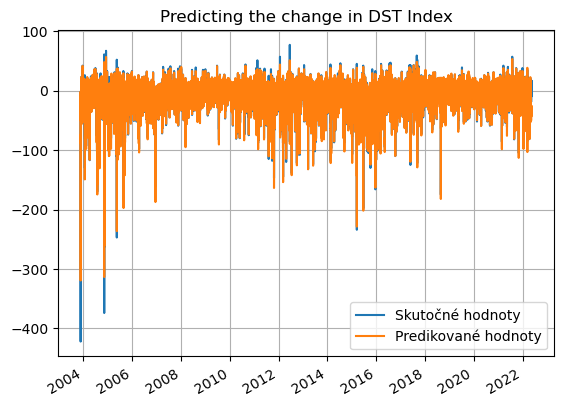

In [13]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [14]:
TN, FP, FN, TP = cm.ravel()
ACC = (TP + TN) / (TP + TN + FP + FN)
MCC = matthews_corrcoef(y_test2, y_pred2)
print("ACC={}".format(ACC))
print("MCC={}".format(MCC))

ACC=0.9605566870332655
MCC=0.8746237463885463
